In [1]:
from pynq import Overlay, MMIO, lib
from pynq.lib.video import VideoMode
from PIL import Image
import cffi
from time import sleep

In [2]:
overlay = Overlay("design_1C.xsa")


In [3]:
class Convolution_Filter:
    def __init__(self, overlay, base_address=0x43C10000, address_range=0x10000, address_offset=0x40):
        self.base_address = base_address
        self.address_range = address_range
        self.address_offset = address_offset
        self.offset = 0x04
        self.mmio = MMIO(base_address, address_range)
        self.conv = overlay.filter.convolution_filter
        
    def update_filter(self, fil):
        if(len(fil) != 51):
            print("filter update")
            
        address = self.address_offset
        data = 0x00000000
        bits_shift = 0
        counter = 0
        
        for el in fil:
            if(bits_shift >= 32):
                self.mmio.write(address, data)
                data = 0x00000000
                bits_shift = 0
                address = address + self.offset
            
            counter += 1
            data = data | (el << bits_shift)
            bits_shift += 8
            if(counter >= 51):
                self.mmio.write(address, data)
    
    def print_filter(self):
        f1 = self.conv.mmio.array.view('int8')[0x40:0x71]
        f2 = self.conv.mmio.array.view('int8')[0x71:0x73]
        
        print(f1.reshape((7,7)))
        print(f2.reshape((1,2)))

In [4]:
class OV7670:
    def __init__(self, iic):
        self.OV7670_SLAVE_ADDRESS = 0x21
        
        _ffi = cffi.FFI()
        self.tx_buf = _ffi.new("unsigned char [32]")
        self.rx_buf = _ffi.new("unsigned char [32]")
        
        self.iic = iic

    def write_register(self, reg, data):
        self.tx_buf[0] = reg
        self.tx_buf[1] = data

        self.iic.send(self.OV7670_SLAVE_ADDRESS, self.tx_buf, 2, 0)

    def read_register(self, reg):
        self.tx_buf[0] = reg

        self.iic.send(self.OV7670_SLAVE_ADDRESS, self.tx_buf, 1, 0)
        self.iic.receive(self.OV7670_SLAVE_ADDRESS, self.rx_buf, 1, 0)

        return self.rx_buf[0]

    def default_setup(self):
        self.write_register(0x12, 0x80)
        sleep(1)
        self.write_register(0x0E, 0x01)
        self.write_register(0x0F, 0x4B)
        self.write_register(0x16, 0x02)
        self.write_register(0x1E, 0x07)
        self.write_register(0x21, 0x02)
        self.write_register(0x22, 0x91)
        self.write_register(0x29, 0x07)
        self.write_register(0x33, 0x0B)
        self.write_register(0x35, 0x0B)
        self.write_register(0x37, 0x1D)
        self.write_register(0x38, 0x01)
        self.write_register(0x0C, 0x00) 
        self.write_register(0x3C, 0x78)
        self.write_register(0x4D, 0x40)
        self.write_register(0x4E, 0x20)
        self.write_register(0x74, 0x10)
        self.write_register(0x8D, 0x4F)
        self.write_register(0x8E, 0x00)
        self.write_register(0x8F, 0x00)
        self.write_register(0x90, 0x00)
        self.write_register(0x91, 0x00)
        self.write_register(0x96, 0x00)
        self.write_register(0x9A, 0x00)
        self.write_register(0xB0, 0x84)
        self.write_register(0xB1, 0x04)
        self.write_register(0xB2, 0x0E)
        self.write_register(0xB3, 0x82)
        self.write_register(0xB8, 0x0A)

In [5]:
iic = overlay.axi_iic
ov7670 = OV7670(iic)
ov7670.default_setup()

In [6]:
sharpen_filter = [
    1, 0, 0, 0, 0, 0, 0,
    0, 1, 0, 0, 0, 0, 0,
    0, 0, 1, 0, 0, 0, 0,
    0, 0, 0, 1, 0, 0, 0,
    0, 0, 0, 0, 1, 0, 0,
    0, 0, 0, 0, 0, 1, 0,
    0, 0, 0, 0, 0, 0, 1,
    7, 0]

neutral_filter = [
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 1, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    1, 0]

vertical_filter = [
	-1, -2, -4, 0, 4, 2, 1,
	-1, -2, -4, 0, 4, 2, 1,
	-2, -4, -6, 0, 6, 4, 2,
	-4, -6, -8, 0, 8, 6, 4,
	-2, -4, -6, 0, 6, 4, 2,
	-1, -2, -4, 0, 4, 2, 1,
	-1, -2, -4, 0, 4, 2, 1,
    120, 127]

fil = Convolution_Filter(overlay)
fil.update_filter(vertical_filter)

In [7]:
# Configuration of vdma with a resolution of 800x600 and 24 bit for each pixel
vdma = overlay.VDMA.axi_vdma

vdma.readchannel.reset()
vdma.readchannel.mode = VideoMode(800, 600, 24)
vdma.readchannel.start()

vdma.writechannel.reset()
vdma.writechannel.mode = VideoMode(800, 600, 24)
vdma.writechannel.start()

frame = vdma.readchannel.readframe() # Needed because first frame is always black

vdma.readchannel.tie(vdma.writechannel) # Connect input directly to output of vdma

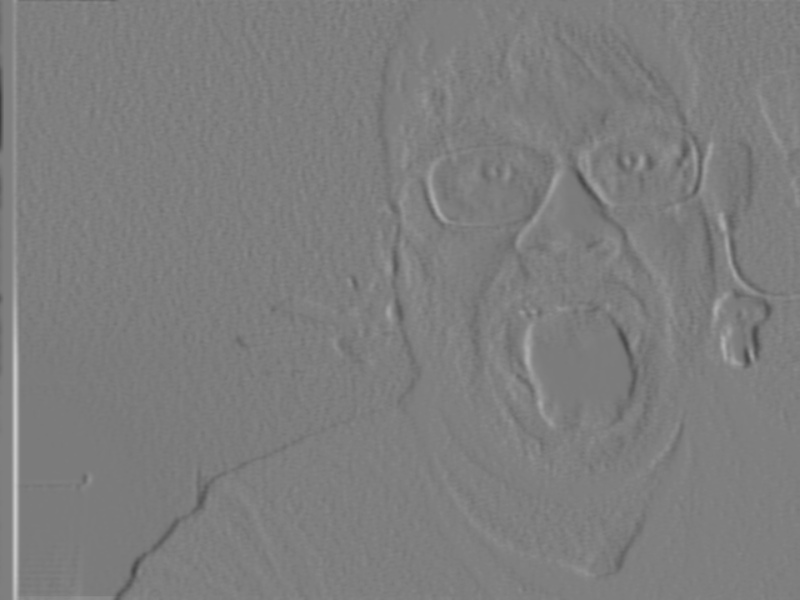

In [9]:
frame = vdma.readchannel.readframe()
img = Image.fromarray(frame, 'RGB')
display(img)
img.save("img.png")

In [36]:
overlay?